In [1]:
import yaml
import healpy as hp
import numpy as np
import os
import scipy

from plancklens import utils

from jointmap.plots import CMBLensingPlot 

from delensalot.core import cachers

import os
import numpy as np

from delensalot.core.iterator import statics

import yaml

import matplotlib.pyplot as plt



mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


## RDN0 tests for cosmic birefringence

In [2]:
def bin_theory(cl, bin_edges):
    l = np.arange(len(cl))
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    el = (bin_edges[1:] + bin_edges[:-1])/2
    return el, cl


bin_edges = np.arange(10, 4000, 20)


def cross_corr_coeff(a, b, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = np.sqrt(x**2 / (aa * bb))
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr


def cross_corr_coeff_from_cl(a, b, x, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(a))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(x)
    el, aa = decorator(a)
    el, bb = decorator(b)
    xcorr = np.sqrt(x**2 / (aa * bb))
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr

In [4]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    

def load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx = 0):
    #input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_olm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_alpha_lm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    inputs = {}
    print("Inputs in", f"{scratch}/{cmbversion}")
    for k in selected:
        input = hp.read_alm(f"{scratch}/{cmbversion}/simswalpha/{input_names[k]}.fits")
        inputs[k] = utils.alm_copy(input, lmax=lmax_rec)
    return inputs


# Function to process a configuration and prepare data for plotting
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin = config["imin"]
    simidx = imin
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"
    print("Reading from", its_folder)
    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

## Showing noise levels

In [7]:
bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)

bin_edges_B = np.arange(2, 10, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(10, 200, 20), np.arange(200, 800, 50), np.arange(800, 4000, 600)])

decorator_WF = lambda x: bin_theory(x, bin_edges)

In [8]:
dir = "/home/users/d/darwish/jointmap/jobs/noise_biases_spt/"
ngg = np.loadtxt(f"{dir}ngg_a_QE.txt")[:5001]
ngg_10 = np.loadtxt(f"{dir}ngg_a_itr_10.txt")[:5001]

In [10]:
selected = ["f", "p"]

In [21]:
alpha = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_p_p_apospt3g_patchy_mf_fp_new_0_54_5.npy")
alpha_cross = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_cross_p_p_apospt3g_patchy_mf_fp_new_0_54_5.npy")
alpha_cross_lensed = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_cross_lensed_p_p_apospt3g_patchy_mf_fp_new_0_54_5.npy")
inputs = np.load("/home/users/d/darwish/scratch/joint_map_outputs/input_apospt3g_patchy_mf_fp_new_0_54_5.npy")
inputs_lensed = np.load("/home/users/d/darwish/scratch/joint_map_outputs/input_lensed_apospt3g_patchy_mf_fp_new_0_54_5.npy")

alpha_cross_split = np.array(np.split(alpha_cross, 2, axis = -1))
alpha_cross_lensed_split = np.array(np.split(alpha_cross, 2, axis = -1))
print(alpha_cross_split.shape)

WFs = alpha_cross_split/np.swapaxes(inputs, 0, 1)[:, :, None, :]
WFsmean = WFs.mean(axis = 1)

WFls = alpha_cross_lensed_split/np.swapaxes(inputs, 0, 1)[:, :, None, :]
WFlsmean = WFls.mean(axis = 1)

inputmean = inputs.mean(axis = 0)

(2, 54, 6, 5001)


/tmp/ipykernel_3103480/3476225140.py:11: RuntimeWarning: invalid value encountered in divide
  WFs = alpha_cross_split/np.swapaxes(inputs, 0, 1)[:, :, None, :]
/tmp/ipykernel_3103480/3476225140.py:14: RuntimeWarning: invalid value encountered in divide
  WFls = alpha_cross_lensed_split/np.swapaxes(inputs, 0, 1)[:, :, None, :]


In [14]:
scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
cmbversion = "fp_new"
version = "apospt3g_patchy_mf"
qe_key = "p_p"
itrs = [0, 5]
Nsims = inputs.shape[0]
crosses_MAP = []
crosses_QE = []
for simidx in range(Nsims):
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"
    print("Reading from", its_folder)
    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)
    QE = plms[0]
    MAP = plms[1]
    QEp, QEf = np.split(QE, 2)
    crosses_QE.append(hp.alm2cl(QEp, QEf))
    MAPp, MAPf = np.split(MAP, 2)
    crosses_MAP.append(hp.alm2cl(MAPp, MAPf))

crosses_QE = np.array(crosses_QE)
crosses_MAP = np.array(crosses_MAP)

Reading from /home/users/d/darwish/scratch/JOINTRECONSTRUCTION//fp_new_version_apospt3g_patchy_mf_recs/p_p_sim0000apospt3g_patchy_mf/
Reading from /home/users/d/darwish/scratch/JOINTRECONSTRUCTION//fp_new_version_apospt3g_patchy_mf_recs/p_p_sim0001apospt3g_patchy_mf/
Reading from /home/users/d/darwish/scratch/JOINTRECONSTRUCTION//fp_new_version_apospt3g_patchy_mf_recs/p_p_sim0002apospt3g_patchy_mf/
Reading from /home/users/d/darwish/scratch/JOINTRECONSTRUCTION//fp_new_version_apospt3g_patchy_mf_recs/p_p_sim0003apospt3g_patchy_mf/
Reading from /home/users/d/darwish/scratch/JOINTRECONSTRUCTION//fp_new_version_apospt3g_patchy_mf_recs/p_p_sim0004apospt3g_patchy_mf/
Reading from /home/users/d/darwish/scratch/JOINTRECONSTRUCTION//fp_new_version_apospt3g_patchy_mf_recs/p_p_sim0005apospt3g_patchy_mf/
Reading from /home/users/d/darwish/scratch/JOINTRECONSTRUCTION//fp_new_version_apospt3g_patchy_mf_recs/p_p_sim0006apospt3g_patchy_mf/
Reading from /home/users/d/darwish/scratch/JOINTRECONSTRUCTION

In [39]:
WFeff = np.array([WFsmean[:, 0, :], WFsmean[:, -1, :]]) #first index is iter, second is field

In [51]:
ngg_AB_0, ngg_AB_10 = np.loadtxt("cross_ngg_phi_tau.txt").T

In [76]:
randomized_cls = []
for i in range(10):
    dir = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/fp_new_version_apospt3g_patchy_mf_recs/p_p_sim{i:04}apospt3g_patchy_mf/"
    randomized_cls.append(hp.alm2cl(np.load(dir+"flm0_11_bh_norm.npy"), np.load(dir+"plm0_11_bh_norm.npy")))
randomized_cls = np.array(randomized_cls)

In [42]:
QE = crosses_QE*(WFeff[0, 0]*WFeff[0, 1])**-1.
MAP = crosses_MAP*(WFeff[1, 0]*WFeff[1, 1])**-1.

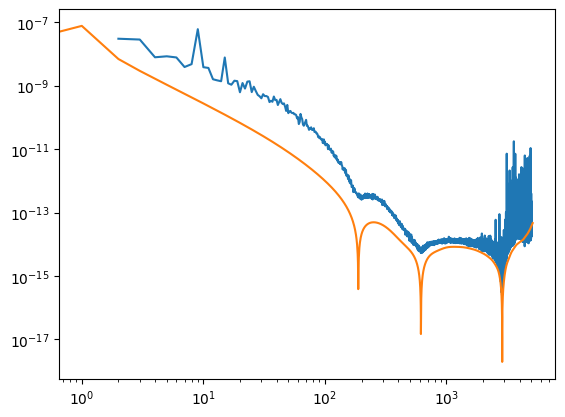

In [53]:
plt.loglog(abs(QE).mean(axis = 0))
plt.plot(abs(ngg_AB_0))

In [ ]:
cls = []
for i in range(54):
    d = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/fp_new_version_apospt3g_patchy_mf_recs/p_p_sim{i:04d}apospt3g_patchy_mf/"
    cls.append(hp.alm2cl(np.load(d+"flm0_norm.npy"), np.load(d+"plm0_norm.npy")))
cls = np.array(cls)

AttributeError: module 'numpy' has no attribute 'aerray'

In [61]:
cls_bh = []
for i in range(40):
    d = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/fp_new_version_apospt3g_patchy_mf_recs/p_p_sim{i:04d}apospt3g_patchy_mf/"
    cls_bh.append(hp.alm2cl(np.load(d+"flm0_bh_norm.npy"), np.load(d+"plm0_bh_norm.npy")))
cls_bh = np.array(cls_bh)

In [62]:
cls = np.array(cls)
cls_bh = np.array(cls_bh)

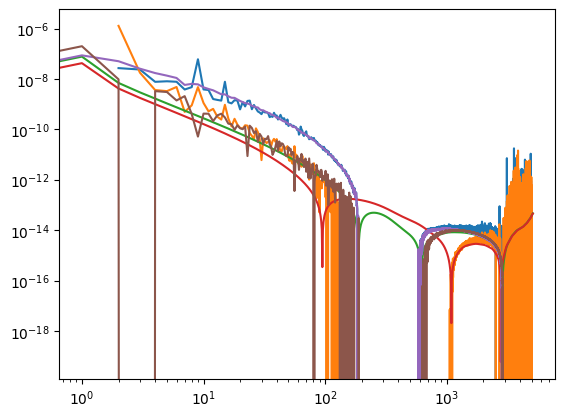

In [69]:
plt.loglog((QE).mean(axis = 0))
plt.loglog((MAP).mean(axis = 0))
plt.plot(abs(ngg_AB_0))
plt.plot(abs(ngg_AB_10))
plt.plot(cls.mean(axis = 0))
plt.plot(-(cls_bh).mean(axis = 0))

In [78]:
n1_cross_f_p = np.loadtxt("../jobs/n1_cross_f_p.txt")

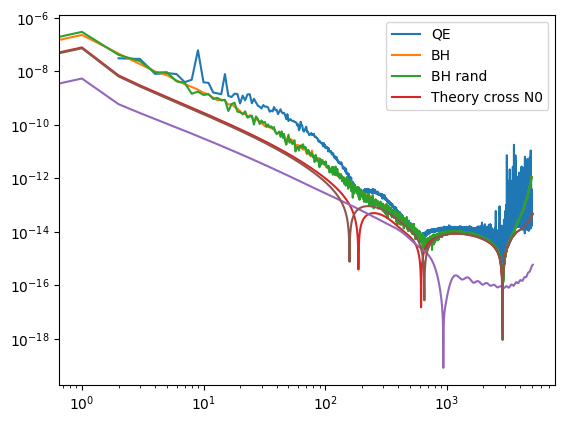

In [81]:
plt.loglog(abs(QE).mean(axis = 0), label = "QE")
plt.plot(abs(cls_bh).mean(axis = 0), label = "BH")
plt.plot(abs(randomized_cls).mean(axis = 0), label = "BH rand")
plt.plot(abs(ngg_AB_0), label = "Theory cross N0")
plt.plot(abs(n1_cross_f_p))
plt.plot(abs(n1_cross_f_p+ngg_AB_0))
plt.legend()

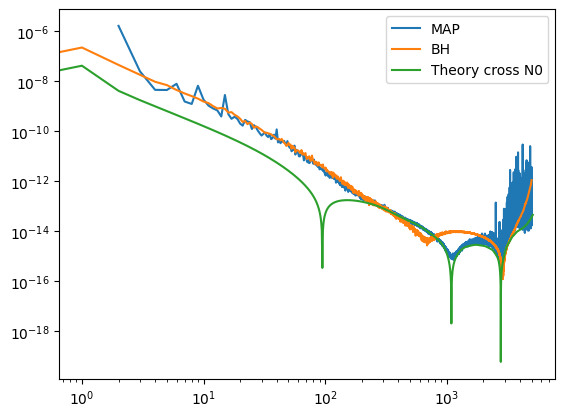

In [74]:
plt.loglog(abs(MAP).mean(axis = 0), label = "MAP")
plt.plot(abs(cls_bh).mean(axis = 0), label = "BH")
plt.plot(abs(ngg_AB_10), label = "Theory cross N0")
plt.legend()

In [12]:
inputs.shape

(54, 2, 5001)

/tmp/ipykernel_357652/3756334904.py:14: RuntimeWarning: invalid value encountered in divide
  WF_0_7 = alpha_0_7_cross[:, :, :5001]/inputs[:, None, :]
/tmp/ipykernel_357652/3756334904.py:17: RuntimeWarning: invalid value encountered in divide
  WF_0_7_mf = alpha_0_7_cross_mf/inputs[0:N, None, :]
/tmp/ipykernel_357652/3756334904.py:20: RuntimeWarning: invalid value encountered in divide
  WF_0_7_lensed = alpha_0_7_cross_lensed[:, :, :5001]/inputs[:, None, :]
/tmp/ipykernel_357652/3756334904.py:23: RuntimeWarning: invalid value encountered in divide
  WF_0_7_lensed_mf = alpha_0_7_cross_lensed_mf/inputs[0:N, None, :]


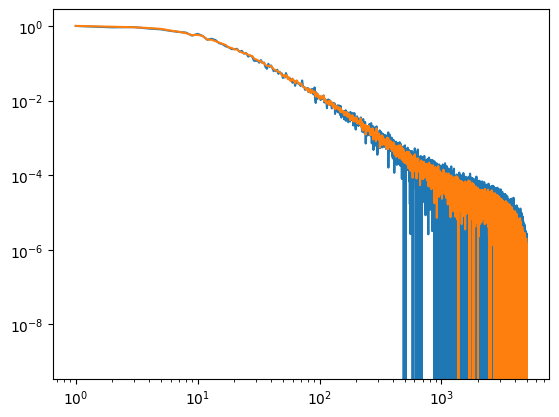

In [13]:
N = 15

alpha_0_7 = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_p_p_apospt3g_apo_new_0_63_15.npy")#[0:N, :, :5001]
alpha_0_7_cross = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_cross_p_p_apospt3g_apo_new_0_63_15.npy")#[0:N, :, :5001]
alpha_0_7_cross_lensed = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_cross_lensed_p_p_apospt3g_apo_new_0_63_15.npy")#[0:N, :, :5001]


alpha_0_7_mf = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_p_p_apospt3g_mf_apo_new_0_20_15.npy")[0:N, :, :5001]
alpha_0_7_cross_mf = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_cross_p_p_apospt3g_mf_apo_new_0_20_15.npy")[0:N, :, :5001]
alpha_0_7_cross_lensed_mf = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_cross_lensed_p_p_apospt3g_mf_apo_new_0_20_15.npy")[0:N, :, :5001]

no_alpha_0_7_mf = np.load("/home/users/d/darwish/scratch/joint_map_outputs/total_qe_it_p_p_apospt3g_mf_ap_p_new_0_15_15.npy")[0:N, :, :5001]

WF_0_7 = alpha_0_7_cross[:, :, :5001]/inputs[:, None, :]
WF_0_7_mean = WF_0_7.mean(axis = 0)

WF_0_7_mf = alpha_0_7_cross_mf/inputs[0:N, None, :]
WF_0_7_mf_mean = WF_0_7_mf.mean(axis = 0)

WF_0_7_lensed = alpha_0_7_cross_lensed[:, :, :5001]/inputs[:, None, :]
WF_0_7_lensed_mean = WF_0_7_lensed.mean(axis = 0)

WF_0_7_lensed_mf = alpha_0_7_cross_lensed_mf/inputs[0:N, None, :]
WF_0_7_lensed_mf_mean = WF_0_7_lensed_mf.mean(axis = 0)


plt.plot(WF_0_7_lensed_mf_mean[-1])
plt.loglog(WF_0_7_lensed_mean[-1])

In [58]:
WFth10_full = cls_alpha/(cls_alpha+ngg_10+n1_ap[:ngg_10.shape[0]])

/tmp/ipykernel_357652/4175193245.py:7: RuntimeWarning: divide by zero encountered in divide
  cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
/tmp/ipykernel_357652/509174289.py:5: RuntimeWarning: invalid value encountered in divide
  cl = cl[0] / sums[0]


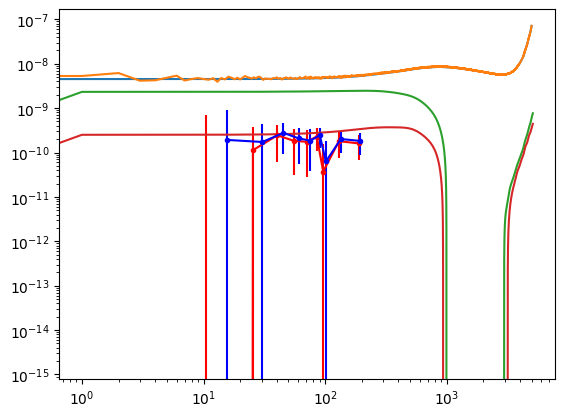

In [70]:
from scipy.interpolate import make_splrep
from plancklens.utils import cli

ns = 1
ACB = 7
ell = np.arange(0, 5000+1)
cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
cls_alpha_th[0] = 0
itr = 5


WF_th_ = WFth10 if itr != 0 else WFth
nx = 1
Wfull = WF_0_7_mf_mean
WFlfull = WF_0_7_lensed_mean
WFcorr_mean = Wfull[itr]*cli(WF_th_)
WFlcorr_mean = WFlfull[itr]*cli(WF_th_)
ells = np.arange(1, 600, 1)
wf_corr_spl = make_splrep(ells, (WFcorr_mean[ells]))(ells)
wfl_corr_spl = make_splrep(ells, (WFlcorr_mean[ells]))(ells)
wf_map = WF_th_[ells]*wf_corr_spl
wfl_map = WF_th_[ells]*wfl_corr_spl
#wf_map = WFth10[ells]


plt.loglog(N0)
plt.plot(meanrand)

bin_edges = np.concatenate([np.arange(3, 100, 15), np.arange(100, 800, 60)])#, np.arange(100, 800, 50), np.arange(800, 5000, 300)])
dec = lambda x: bin_theory(x, bin_edges)


R = cli(ngg_10) #true normalization
meanrands_set = meanrands3
mean_0_set = meanrands_set.mean(axis = 0).T[0]

kR_eff = R[ells] * make_splrep(ells, mean_0_set[ells]/ff[ells]*cli(R[ells]), k = 5)(ells)
meanrands_set1 = meanrands[:, ells, 0]/ff[None, ells]
rdn0 = meanrands_set1.mean(axis = 0)*cli(kR_eff)**2

WFrdn0 = cls_alpha_th[ells]/(cls_alpha_th[ells]+rdn0)

noise = rdn0 if itr != 0 else ngg[ells]

WFF = WFth10[ells]#wf_map

res_rands = alpha_0_7_mf[..., ells]*WFF**-2.-noise-inputmean[ells]

std_mean = res_rands.std(axis = 0)[itr]/np.sqrt(res_rands.shape[0])

res_rand = alpha_0_7_mf.mean(axis = 0)[itr][ells]*WFF**-2.-noise-inputmean[ells]
elb, resb = dec(res_rand)
elb, stds = dec(std_mean)
sel = (elb<200) #& (elb>20)
plt.errorbar(elb[sel], (resb)[sel], stds[sel], color = "red", marker = ".", ls = "-")
#plt.errorbar(elb[sel], a5, b5, color = "orange", marker = ".", ls = "-")

#np.savetxt("res_rand_spt_3g.txt", np.array([elb[sel], resb[sel], stds[sel]]).T, header="ell, res, std")

res_rand = no_alpha_0_7_mf.mean(axis = 0)[itr][ells]*WFF**-2.-noise
elb, resb = dec(res_rand)
elb, stds = dec(std_mean)
plt.errorbar(elb[sel]+5, (resb)[sel], stds[sel], color = "blue", marker = ".", ls = "-")


plt.plot(n1_ap_QE)
plt.plot(n1_ap)

In [29]:
a5, b5 = (resb)[sel], stds[sel]

In [64]:
std_mean.shape

(16, 400)

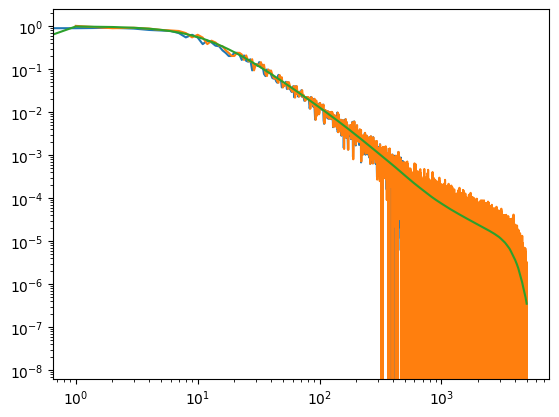

In [17]:
plt.loglog(wf_map)
plt.plot(WF_0_7_lensed_mean[itr])
plt.plot(WFth10)

In [60]:
autoQE = alpha[:, 0, :]
crossQE = alpha_cross[:, 0, :]
WFQE = WFs[:, 0, :]
WFlQE = WFls[:, 0, :]

WFQEmean = WFsmean[0]
WFlQEmean = WFlsmean[0]

In [61]:
autoQE_thnorm = autoQE*WFth**-2.
autoQE_empnorm = autoQE*WFQEmean**-2.
autoQE_emplnorm = autoQE*WFlQEmean**-2.

/tmp/ipykernel_3058873/727192048.py:1: RuntimeWarning: divide by zero encountered in power
  autoQE_thnorm = autoQE*WFth**-2.
/tmp/ipykernel_3058873/727192048.py:1: RuntimeWarning: invalid value encountered in multiply
  autoQE_thnorm = autoQE*WFth**-2.


In [62]:
#n1aa_der = np.loadtxt("n1_aa_derot.txt")
#n1aa = np.loadtxt(f"noise_biases/n1_aa_itr_10.txt")

ns = 1
ACB = 7
ell = np.arange(0, 5000+1)
cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
cls_alpha_th[0] = 0


"""plt.loglog(n1aa_der, lw = 2)
plt.loglog(n1aa)"""

/tmp/ipykernel_3058873/239185149.py:7: RuntimeWarning: divide by zero encountered in divide
  cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns


'plt.loglog(n1aa_der, lw = 2)\nplt.loglog(n1aa)'

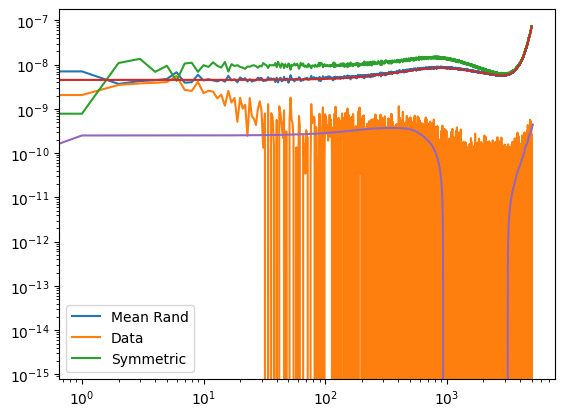

In [13]:
NNs = 8
meanrand = 0
meanrand_no_alpha = 0
Nsims = 4
meanrands = []
for xs in range(Nsims):
    #newrand_no_alpha = np.array([np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_recs/p_p_sim{xs:04}apo_new_official_check_factor_2_vofficial_no_alpha/"+f"plm_N0p015_vrandnew_sim{i:04}.npy")*ff for i in range(NNs)])
    newrand = np.array([np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_recs/p_p_sim{xs:04}apospt3g/"+f"plm_N0p015_v4_vrandnew2_sims_v2_sim{i:04}.npy")*ff[:, None] for i in range(NNs)])
    meanrand += newrand.mean(axis = 0)
    meanrands.append(newrand.mean(axis = 0))
    if xs == 31:
        meanrand32 = meanrand.copy()
        meanrand32 /= 32
    #meanrand_no_alpha += newrand_no_alpha.mean(axis = 0)


meanrands = np.array(meanrands)
meanrand /= Nsims
meanrand_no_alpha /= Nsims

meanrand, meandata, meansymm = meanrand.T
#meansymm /= 2

plt.loglog(meanrand, label = "Mean Rand")

plt.plot(-(meandata-meanrand), label = "Data")

plt.plot((meansymm-meanrand), label = "Symmetric")

plt.plot(N0)

plt.plot(n1_ap)

plt.legend()

/tmp/ipykernel_3058873/2290788138.py:13: RuntimeWarning: invalid value encountered in divide
  rho = alpha_cross/np.sqrt(inputs[:, None, :]*alpha)


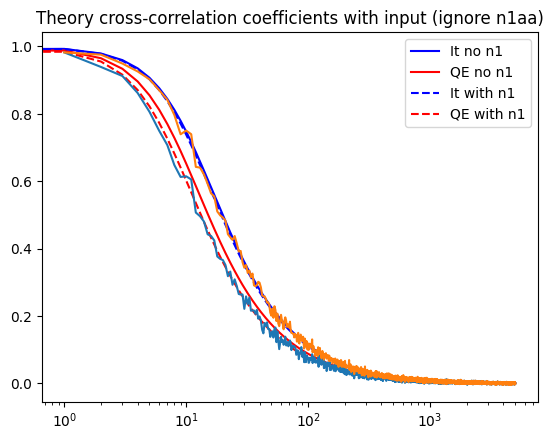

In [38]:
theory_cross_coeff = lambda x: np.sqrt(cls_alpha_th/(cls_alpha_th+ngg+x*n1_ap_QE[:5001]))
theory_cross_coeff_10 = lambda x: np.sqrt(cls_alpha_th/(cls_alpha_th+ngg_10+x*n1_ap[:5001]))

plt.title("Theory cross-correlation coefficients with input (ignore n1aa)")

plt.plot(theory_cross_coeff_10(0), label = "It no n1", color = "blue")
plt.plot(theory_cross_coeff(0), label = "QE no n1", color = "red")

plt.plot(theory_cross_coeff_10(1), label = "It with n1", ls = "--", color = "blue")
plt.plot(theory_cross_coeff(1), label = "QE with n1", ls = "--", color = "red")


rho = alpha_cross/np.sqrt(inputs[:, None, :]*alpha)
rho = rho.mean(axis = 0)
plt.plot(rho[0])
plt.plot(rho[-1])




plt.xscale("log")
plt.legend()

In [35]:
rho.shape

(63, 16, 5001)

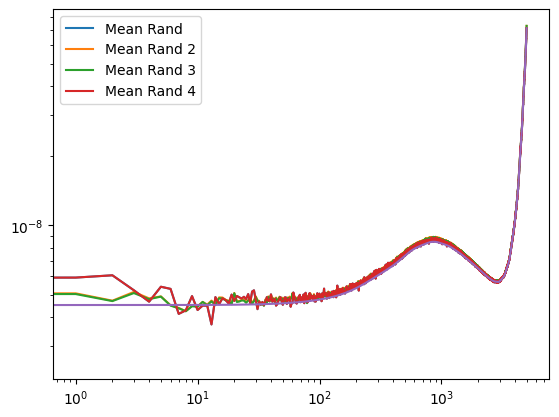

In [63]:
NNs = 12
meanrand = 0
meanrand_no_alpha = 0
Nsims = 8
meanrands = []
meanrands2 = []
meanrands3 = []
meanrands4 = []
for xs in range(Nsims):
    #newrand_no_alpha = np.array([np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_recs/p_p_sim{xs:04}apo_new_official_check_factor_2_vofficial_no_alpha/"+f"plm_N0p015_vrandnew_sim{i:04}.npy")*ff for i in range(NNs)])
    newrand = np.array([np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_recs/p_p_sim{xs:04}apospt3g/"+f"plm_N0p015_v4_vrandnew2_sims_v2_sim{i:04}.npy")*ff[:, None] for i in range(28)])
    meanrand += newrand.mean(axis = 0)
    meanrands.append(newrand.mean(axis = 0))
    newrand = np.array([np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_recs/p_p_sim{xs:04}apospt3g/"+f"plm_N0p015_v4_vrandnew2_sims_v3_sim{i:04}.npy")*ff[:, None] for i in range(30)])
    meanrands2.append(newrand.mean(axis = 0))

    newrand = np.array([np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_mf_recs/p_p_sim{xs:04}apospt3g_mf/"+f"plm_N0p015_v4_vrandnew2_sims_v3_sim{i:04}.npy")*ff[:, None] for i in range(30)])
    meanrands3.append(newrand.mean(axis = 0))

    newrand = np.array([np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_recs/p_p_sim{xs:04}apospt3g/"+f"plm_N0p015_v4_vrandnew2_sims_v2_sim{i:04}.npy")*ff[:, None] for i in range(28)])
    meanrands4.append(newrand.mean(axis = 0))
    
    if xs == 31:
        meanrand32 = meanrand.copy()
        meanrand32 /= 32
    #meanrand_no_alpha += newrand_no_alpha.mean(axis = 0)


meanrands = np.array(meanrands)
meanrand /= Nsims

meanrand, meandata, meansymm = meanrands.mean(axis = 0).T

meanrands2 = np.array(meanrands2)
meanrand2, meandata2, meansymm2 = meanrands2.mean(axis = 0).T

meanrands3 = np.array(meanrands3)
meanrand3, meandata3, meansymm3 = meanrands3.mean(axis = 0).T

meanrands4 = np.array(meanrands4)
meanrand4, meandata4, meansymm4 = meanrands4.mean(axis = 0).T

meanrand_no_alpha /= Nsims

a = newrand.mean(axis = 0)
#plt.loglog(a, label = "Single Rand")

#plt.plot(meanrand_no_alpha)
#plt.plot(meanrand32, ls = "--")
plt.loglog(meanrand, label = "Mean Rand")

plt.plot(meanrand2, label = "Mean Rand 2")

plt.plot(meanrand3, label = "Mean Rand 3")

plt.plot(meanrand4, label = "Mean Rand 4")

plt.plot(N0)

plt.legend()

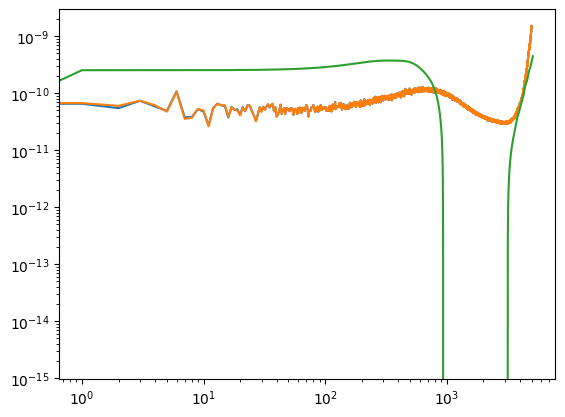

In [16]:
mf = np.load("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_mf_recs/p_p_sim0000apospt3g_mf/plm_gradpdet_it001_sim1001.npy")
plt.loglog(hp.alm2cl(mf[0])*ff)
mf = np.load("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apospt3g_mf_recs/p_p_sim0000apospt3g_mf/plm_gradpdet_it014_sim1001.npy")
plt.loglog(hp.alm2cl(mf[0])*ff)
plt.plot(n1_ap)

In [58]:
#WF, WFl = np.load("WFS_10.txt.npy").T

/tmp/ipykernel_1720377/3174649887.py:1: RuntimeWarning: invalid value encountered in divide
  WFs = alpha_cross/inputs[:, None, :]
/tmp/ipykernel_1720377/3174649887.py:4: RuntimeWarning: invalid value encountered in divide
  WFsa = alpha/inputs[:, None, :]


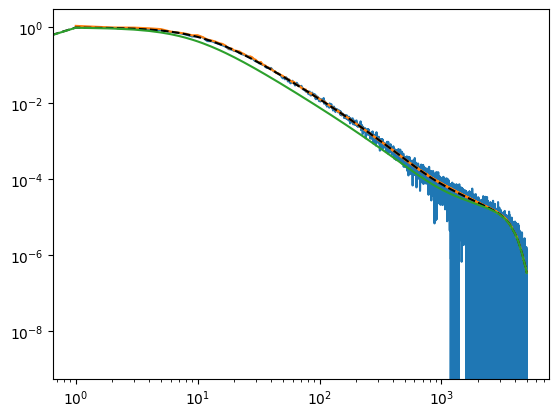

In [59]:
WFs = alpha_cross/inputs[:, None, :]
WFsmean = WFs.mean(axis = 0)

WFsa = alpha/inputs[:, None, :]
WFsmeana = WFsa.mean(axis = 0)

#plt.plot(WFs[0, -1, :])
#plt.plot(WF)
plt.loglog(WFsmean[-1])
plt.plot(WFsmeana[-1])
plt.plot(WFth10, color = "black", ls = "--")

plt.plot(WFth)

/tmp/ipykernel_2835815/373449273.py:4: RuntimeWarning: divide by zero encountered in divide
  cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns


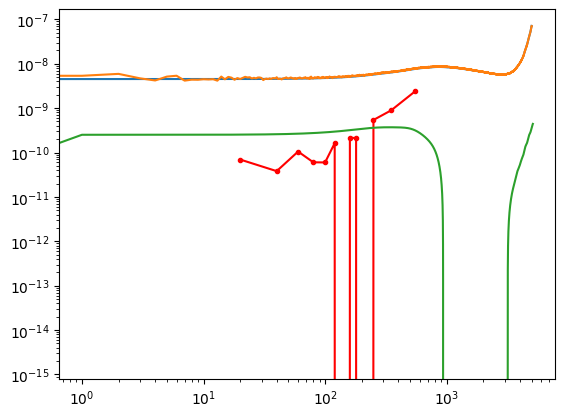

In [29]:
ns = 1
ACB = 7
ell = np.arange(0, 5000+1)
cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
cls_alpha_th[0] = 0
itr = -1

autoMAP = alpha[:, itr, :]
#autonoalphaMAP = no_alpha[:, itr, :]
crossMAP = alpha_cross[:, itr, :]
WFMAP = WFs[:, itr, :]
WFlMAP = WFls[:, itr, :]
inputmean = inputs.mean(axis = 0)

WF = WFMAP.mean(axis = 0)
WFl = WFlMAP.mean(axis = 0)


plt.loglog(N0)
plt.plot(meanrand)

WFthnew = cls_alpha_th[:5001]/(N0+cls_alpha_th[:5001])



bin_edges = np.concatenate([np.arange(10, 200, 20), np.arange(200, 400, 100), np.arange(400, 5000, 300)])
dec = lambda x: bin_theory(x, bin_edges)

res_rand = autoMAP.mean(axis = 0)*WFl**-2.-N0-inputmean
elb, resb = dec(res_rand)
sel = elb<600
plt.plot(elb[sel], (resb)[sel], color = "red", marker = ".", ls = "-")
#np.savetxt("res_rand.txt", np.array([elb[sel], resb[sel]]).T)

res_rand = autoMAP.mean(axis = 0)*WF**-2.-N0-inputmean
elb, resb = dec(res_rand)
#plt.plot(elb, (resb), color = "orange")

#plt.plot(*dec(res_QE), color = "brown")

plt.plot(n1_ap)

/tmp/ipykernel_2835815/1854405101.py:7: RuntimeWarning: divide by zero encountered in divide
  cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
/tmp/ipykernel_2835815/509174289.py:5: RuntimeWarning: invalid value encountered in divide
  cl = cl[0] / sums[0]


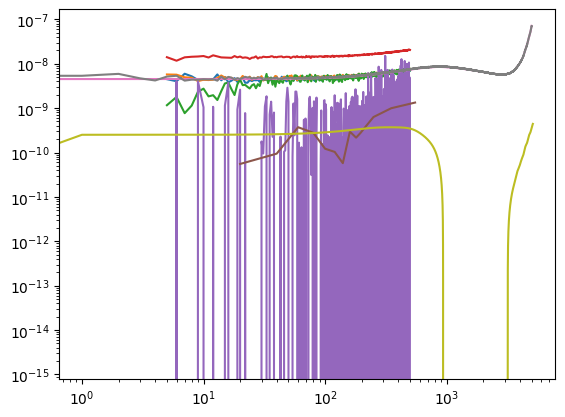

In [30]:
from scipy.interpolate import make_splrep
from plancklens.utils import cli

ns = 1
ACB = 7
ell = np.arange(0, 5000+1)
cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
cls_alpha_th[0] = 0

nx = 1
WFMAPs = WFMAP[nx:]
WFlMAPs = WFlMAP[nx:]
Wfull = WFMAPs*cli(WFth[None, :])
WFlfull = WFlMAPs*cli(WFth[None, :])
WFcorr_mean = np.mean(Wfull, axis = 0)
WFlcorr_mean = np.mean(WFlfull, axis = 0)
ells = np.arange(5, 500)
wf_corr_spl = make_splrep(ells, (WFcorr_mean[ells]))(ells)
wfl_corr_spl = make_splrep(ells, (WFlcorr_mean[ells]))(ells)
wf_map = WFth[ells]*wf_corr_spl
wfl_map = WFth[ells]*wfl_corr_spl

itr = -1

autoMAP = alpha[:nx, itr, :]

crossMAP = alpha_cross[:nx, itr, :]
inputmean = inputs[:nx, :].mean(axis = 0)[ells]

R = cli(N0) #true normalization
meanrands_set = meanrands[nx:]
mean_0_set = meanrands_set.mean(axis = 0).T[0]

kR_eff = R[ells] * make_splrep(ells, mean_0_set[ells]/ff[ells]*cli(R[ells]))(ells)
meanrands_set1 = meanrands[:nx, ells, 0]/ff[None, ells]
rdn0 = meanrands_set1.mean(axis = 0)*cli(kR_eff)**2


plt.plot(ells, rdn0)
plt.plot(ells, meanrands[:nx, ells].mean(axis = 0))


auto = autoMAP.mean(axis = 0)[ells]*wfl_map**-2.
residual = auto-inputmean-rdn0
plt.loglog(ells, residual)
el, x = dec(residual)
plt.plot(el, abs(x))


#autonoalphaMAP = no_alpha[:, itr, :]
crossMAP = alpha_cross[:nx, itr, :]
inputmean = inputs.mean(axis = 0)


plt.loglog(N0)
plt.plot(meanrand)

"""bin_edges = np.concatenate([np.arange(10, 200, 20), np.arange(200, 400, 100), np.arange(400, 5000, 300)])
dec = lambda x: bin_theory(x, bin_edges)

res_rand = autoMAP.mean(axis = 0)*WFl**-2.-N0-inputmean
elb, resb = dec(res_rand)
sel = elb<600
plt.plot(elb[sel], (resb)[sel], color = "red", marker = ".", ls = "-")
#np.savetxt("res_rand.txt", np.array([elb[sel], resb[sel]]).T)

res_rand = autoMAP.mean(axis = 0)*WF**-2.-N0-inputmean
elb, resb = dec(res_rand)"""
#plt.plot(elb, (resb), color = "orange")

#plt.plot(*dec(res_QE), color = "brown")

plt.plot(n1_ap)

In [27]:
meanrands.shape

(16, 5001, 3)

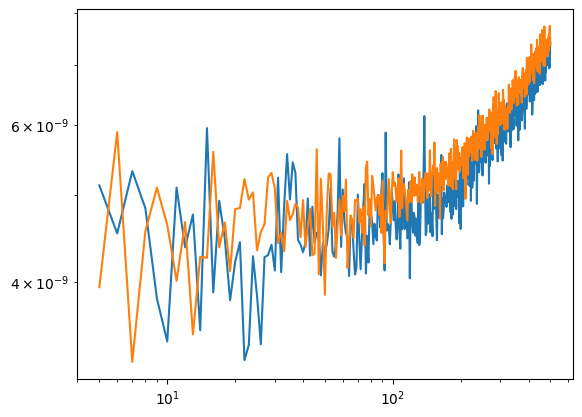

In [105]:
plt.plot(ells, rdn0)
plt.loglog(ells, meanrands[:nx, ells].mean(axis = 0))

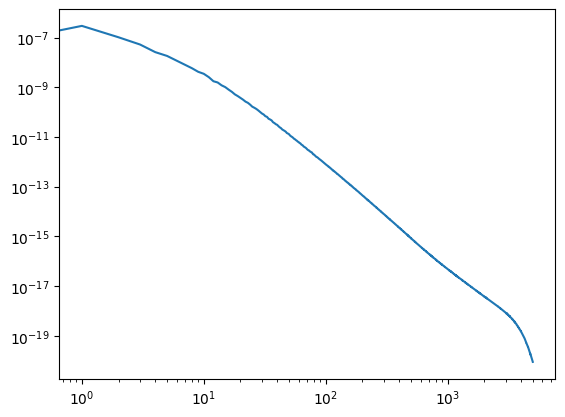

In [24]:
#plt.loglog(no_alpha_a_disabled.mean(axis = 0)[-1])
plt.loglog(alpha.mean(axis = 0)[-1])
#plt.loglog(no_alpha.mean(axis = 0)[-1])
#plt.loglog(no_alpha_no_omega_a_disabled.mean(axis = 0)[-1], ls = "--")

In [158]:
dd = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_v2_nonzero_version_apo_new_v2_nonzero_official_check_factor_2_vofficial_recs/p_p_sim0000apo_new_v2_nonzero_official_check_factor_2_vofficial/"
mfs1 = np.mean([np.load(dd+f"plm_gradpdet_it001_sim{1000+i}.npy")[0] for i in range(4)], axis = 0)
mfs = np.mean([np.load(dd+f"plm_gradpdet_it015_sim{1000+i}.npy")[0] for i in range(4)], axis = 0)

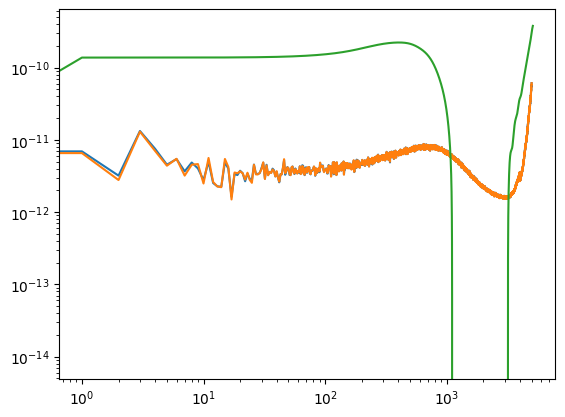

In [159]:
plt.plot(hp.alm2cl(mfs1)*N0**2)
plt.plot(hp.alm2cl(mfs)*N0**2)
plt.loglog(n1_ap)

In [25]:
itr = -1
autoMAP = alpha[:, itr, :]
#autonoalphaMAP = no_alpha[:, itr, :]
crossMAP = alpha_cross[:, itr, :]
WFMAP = WFs[:, itr, :]
WFlMAP = WFls[:, itr, :]

WFMAPmean = WFsmean[itr]
WFlMAPmean = WFlsmean[itr]


norm = WFMAPmean**-2.
norm = WFth**-2. if itr == 0 else WFth10**-2.
#no_alpha_ = autonoalphaMAP.mean(axis = 0)*norm
#elb, no_alphab = dec(no_alpha_)
with_alpha_ = autoMAP.mean(axis = 0)*norm-cls_alpha[:5001]
elb, alphab = dec(with_alpha_)

#plt.loglog(with_alpha_-no_alpha_, color = "Orange")
plt.plot(elb, alphab-no_alphab, color = "Orange")
#plt.loglog(n1aa, color = "red", ls = "--")
#plt.plot(n1aa_der, color = "red", ls = "--", lw = 2)
#plt.plot(n1_aa_QE, color = "green", ls = "--")

plt.show()

#####################################################

ns = 1
ACB = 7
ell = np.arange(0, 5000+1)
cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
cls_alpha_th[0] = 0

norm = WFlMAPmean**-2.
#norm = WFsmeana[-1]**-2.
noise = ngg if itr == 0 else ngg_10
N = meanrand if itr != 0 else ngg


#res_rand = autonoalphaMAP.mean(axis = 0)*norm-N
#elb, resb = dec(res_rand)
plt.plot(elb, -resb, color = "black")
plt.plot(-res_rand, color = "black", alpha = 0.1)

res_rand = autoMAP.mean(axis = 0)*norm-N-inputmean
elb, resb = dec(res_rand)
plt.plot(elb, -resb, color = "red")

plt.plot(*dec(res_QE), color = "brown")
plt.loglog(n1_ap_QE, color = "brown", ls = "--")

plt.loglog(n1_ap, ls = "--")

plt.show()



/tmp/ipykernel_3801824/2584181342.py:13: RuntimeWarning: divide by zero encountered in power
  norm = WFth**-2. if itr == 0 else WFth10**-2.
/tmp/ipykernel_3801824/2584181342.py:16: RuntimeWarning: invalid value encountered in multiply
  with_alpha_ = autoMAP.mean(axis = 0)*norm-cls_alpha[:5001]


NameError: name 'no_alphab' is not defined

/tmp/ipykernel_3460414/536921174.py:4: RuntimeWarning: divide by zero encountered in divide
  cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
/tmp/ipykernel_3460414/536921174.py:51: RuntimeWarning: divide by zero encountered in power
  res_rand = autoMAP.mean(axis = 0)*WFth10**-2.-N0-inputmean
/tmp/ipykernel_3460414/536921174.py:51: RuntimeWarning: invalid value encountered in multiply
  res_rand = autoMAP.mean(axis = 0)*WFth10**-2.-N0-inputmean


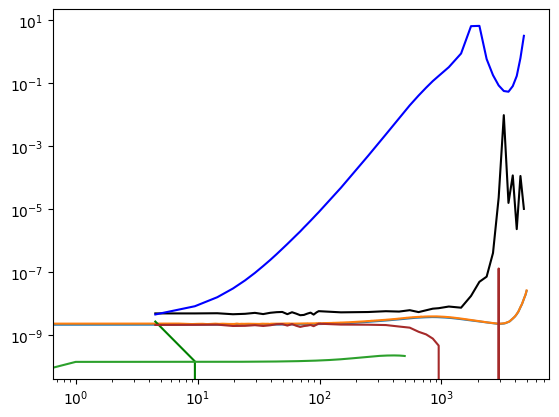

In [80]:
ns = 1
ACB = 7
ell = np.arange(0, 5000+1)
cls_alpha_th = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
cls_alpha_th[0] = 0

#plt.plot(means[0])
"""plt.plot(randmeans[1:].mean(axis = 0), alpha = 0.4)


NN = 40
Rnew = meanrands[NN:].mean(axis = 0)**-1.
newmean = randmeans[0]/ff*Rnew**-2.
newmean = randmeans[:NN].mean(axis = 0)/ff*Rnew**-2."""

plt.loglog(N0)
#plt.plot(n1aa)
plt.plot(meanrand)

WF_corr = np.nan_to_num(WFl/WFthnew)
from scipy.interpolate import UnivariateSpline
el = np.concatenate([np.arange(1, 300, 10), np.arange(300, 1500, 500)])
corr = UnivariateSpline(el, WF_corr[el])(elb) 
WFmap = np.interp(elb, np.arange(WFth10.size), WFth10)*corr

no_alphab *= WFmap**-2.
meanrandb = dec(meanrand)[1]


res_rands = autonoalphaMAP*WFMAPmean**-2.-meanrands
res_rands_std = np.std(res_rands, axis = 0)


NN = 64
RDN0 = meanrands[:NN].mean(axis = 0) #average N0, assume it is the truth
RDN02 = meanrands[NN:].mean(axis = 0)*ff**-1
RDN02 *= RDN0**2 

WFthnew = cls_alpha_th[:5001]/(N0+cls_alpha_th[:5001])

res_rand = autonoalphaMAP.mean(axis = 0)*WFMAPmean**-2.-meanrand_no_alpha
#res_rand = autonoalphaMAP.mean(axis = 0)*WFthnew**-2.-RDN02
elb, resb = dec(res_rand)
plt.plot(elb, resb, color = "black")
plt.plot(elb, no_alphab-meanrandb, color = "blue")

res_rand = autonoalphaMAP.mean(axis = 0)-meanrand_no_alpha
elb, resb = dec(res_rand)
plt.plot(elb, resb, color = "green")

res_rand = autoMAP.mean(axis = 0)*WFth10**-2.-N0-inputmean
elb, resb = dec(res_rand)
plt.plot(elb, resb, color = "red")

plt.plot(*dec(res_QE), color = "brown")

plt.plot(n1_ap)

(1e-09, 1e-08)

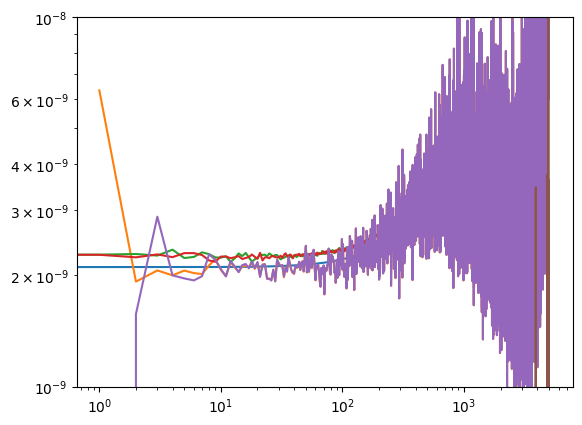

In [23]:
NN = 64
RDN0 = meanrands[:NN].mean(axis = 0) #average N0, assume it is the truth
RDN02 = meanrands[NN:].mean(axis = 0)#*ff**-1

meanrand_no_alpha


plt.plot(N0)
tot = autonoalphaMAP.mean(axis = 0)*WFlMAPmean**-2.
plt.loglog(tot)
plt.plot(RDN02)
plt.plot(RDN0)

tota = autoMAP.mean(axis = 0)*WFlMAPmean**-2.
plt.plot(tota-inputmean)

plt.plot(tota-inputmean-tot)
#plt.plot(-tot+RDN0)
#plt.plot(abs(n1_ap))

plt.plot(n1aa)
plt.ylim(1e-9, 1e-8)
plt.ylim(ymax = 1e-8)



In [24]:
RDN0 = meanrands[:NN].mean(axis = 0) #average N0, assume it is the truth
RDN02 = meanrands[NN:].mean(axis = 0)*ff**-1
RDN02 *= RDN0 

In [148]:
import numpy as np
from scipy.signal import savgol_filter

def smooth_curve(x, y, method='savgol', window=11, poly_order=3):
    """
    Smooth a curve using either Savitzky-Golay filter or moving average.
    
    Parameters:
    x: array-like, x coordinates
    y: array-like, y coordinates to smooth
    method: str, 'savgol' or 'moving_average'
    window: int, window size (must be odd for savgol)
    poly_order: int, polynomial order for savgol filter
    
    Returns:
    smoothed y values
    """
    if method == 'savgol':
        # Ensure window is odd
        window = window + 1 if window % 2 == 0 else window
        return savgol_filter(y, window, poly_order)
    
    elif method == 'moving_average':
        return np.convolve(y, np.ones(window)/window, mode='valid')

# Example usage:
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, 100)  # Noisy sine wave

# Using Savitzky-Golay
y_smooth_sg = smooth_curve(x, y, method='savgol', window=11, poly_order=3)

# Using moving average
y_smooth_ma = smooth_curve(x, y, method='moving_average', window=5)

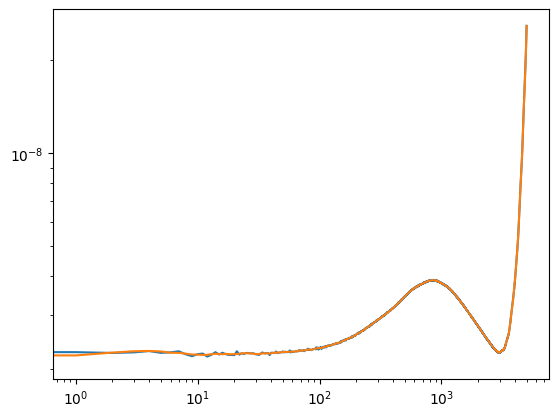

In [149]:
ls = np.arange(meanrand.size)
plt.loglog(meanrand)
plt.plot(smooth_curve(ls, meanrand))


/tmp/ipykernel_3460414/1908436678.py:1: RuntimeWarning: divide by zero encountered in power
  res = no_alpha[:, -1, :].mean(axis = 0)*WFth10**-2.-meanrand
/tmp/ipykernel_3460414/1908436678.py:1: RuntimeWarning: invalid value encountered in multiply
  res = no_alpha[:, -1, :].mean(axis = 0)*WFth10**-2.-meanrand


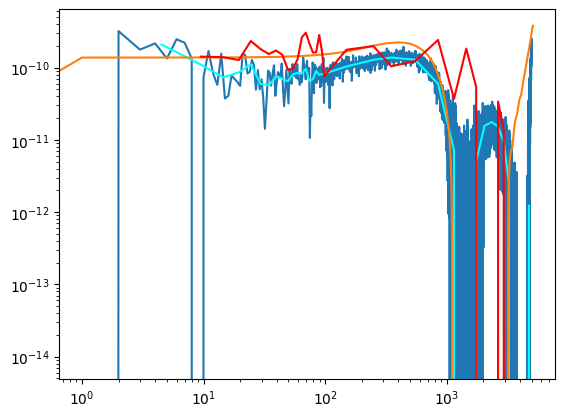

In [153]:
res = no_alpha[:, -1, :].mean(axis = 0)*WFth10**-2.-meanrand
plt.loglog(-res)
elb, resb = dec(res)
plt.plot(elb, -resb, color = "cyan")

plt.plot(n1_ap)

#plt.loglog(no_alpha.mean(axis = 0)-meanrand_no_alpha)

WFlMAPmeansmoothed = smooth_curve(ls, WFlMAPmean)
meanrandsmoothed = smooth_curve(ls, meanrand)
noalphasmoothed = smooth_curve(ls, no_alpha[:, -1, :].mean(axis = 0))

res_rand = noalphasmoothed*WFlMAPmeansmoothed**-2.-meanrandsmoothed
elb, resb = dec(-res_rand)
plt.plot(elb, resb, color = "red")

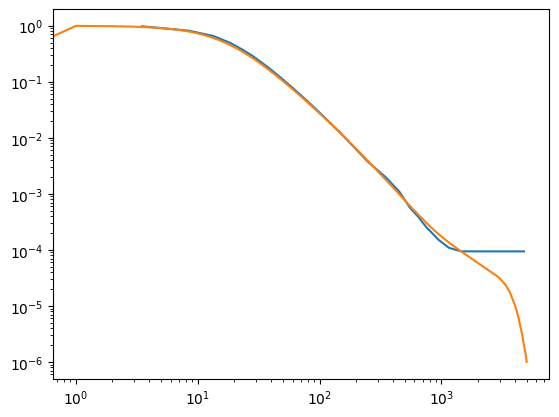

In [208]:
plt.loglog(elb, WFmap)
plt.plot(WFth10)

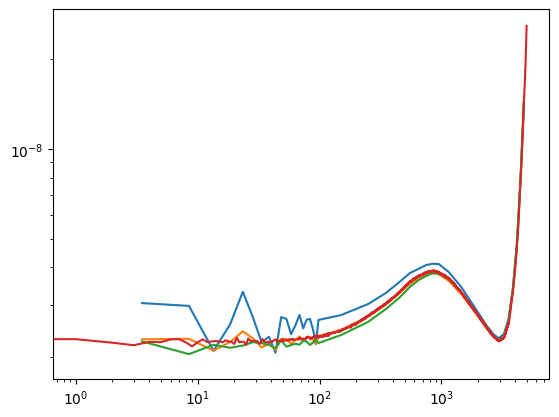

In [122]:
plt.plot(*dec(newmean))
plt.loglog(*dec(means.mean(axis = 0)))
plt.plot(*dec(alms_no_alpha.mean(axis = 0)))
plt.plot(randmeans.mean(axis = 0))

In [31]:
from scipy.interpolate import UnivariateSpline

MAP = alms[0]*WFth10**2. #raw MAP
WF_corr = np.nan_to_num(WF/WFth10)
el = np.arange(1, 1500, 10)
el = np.concatenate([np.arange(1, 300, 10), np.arange(300, 1500, 200)])
#el = np.logspace(0, 3, 100)
corr = UnivariateSpline(el, WF_corr[el])(el) 
WFmap = WFth10[el]*corr

MAP_no_alpha = alms_no_alpha[0]*WFth10**2.
MAP_no_alpha = alms_no_alpha.mean(axis = 0)*WFth10**2.

MAPWF = MAP[el]*WFmap**-2.
MAP_no_alphaWF = MAP_no_alpha[el]*WFmap**-2.


RDN0 = means[0]*ff**-1.
RDN0_simset = np.mean(means[1:], axis = 0)*ff**-1.
Respcorr = utils.cli(N0[el])*UnivariateSpline(el, RDN0_simset[el]*N0[el])(el)
NormRDN0 = RDN0[el]*utils.cli(Respcorr)**2.

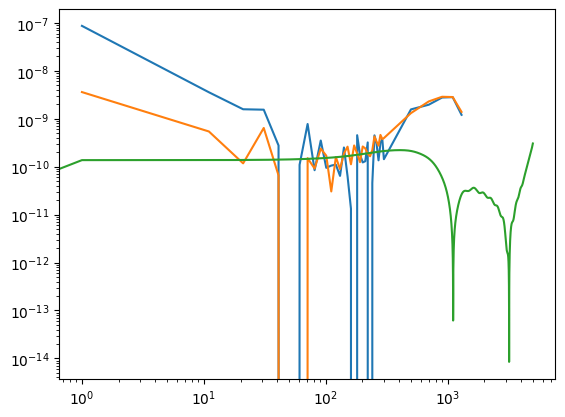

In [32]:
plt.loglog(el, MAPWF-NormRDN0)
plt.plot(el, MAP_no_alphaWF-NormRDN0)
plt.plot(abs(n1_ap[:5001]))

(1.1072318861963556e-09, 1e-08)

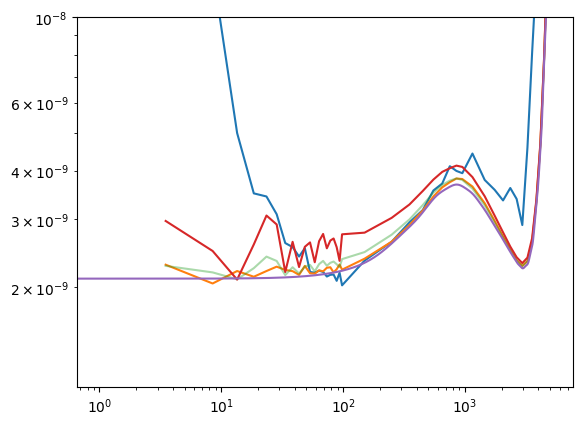

In [164]:
#a = hp.alm2cl(plm0_i_j_A)
#plt.loglog(a*ff)
"""a = hp.alm2cl(plm0_i_j_A_new)
plt.loglog(a*ff)"""
"""b = hp.alm2cl(plm0_i_i_A_new)
plt.loglog(b*ff)"""

"""b = hp.alm2cl(plm0_j_d_A_new)
plt.loglog(b*ff)

b = hp.alm2cl(plm0_d_d_A_new)
plt.loglog(b*ff)"""

WF, WFl = np.load("WFS_10.txt.npy").T
el, WFb = dec(WF)
el, WFlb = dec(WFl)

el, WFthb = dec(WFth10)

el, totb = dec(alms[1:].mean(axis = 0)*WFth10**2/WFl**2)
plt.plot(el, totb)
el, tot_noalphab = dec(alms_no_alpha[1:].mean(axis = 0))
plt.plot(el, tot_noalphab)

el, n0 = dec(means[1:].mean(axis = 0))
plt.plot(el, n0, alpha = 0.4)

Rnew = means[8:].mean(axis = 0)**-1.
newmean = means[0]/ff*Rnew**-2.

newmean = means[:8].mean(axis = 0)/ff*Rnew**-2.
el, newmb = dec(newmean)
plt.plot(el, newmb)

plt.loglog(N0)
#plt.plot(n1aa)

#plt.loglog(alms_no_alpha.mean(axis = 0))

res = alms_no_alpha.mean(axis = 0)-Rnew**-1
#plt.plot(res)
#plt.plot(*dec(res))
#plt.plot(n1_ap[:5001])

"""residual = total-newmean-cls_alpha
#plt.plot(residual)
plt.plot(*dec(-residual))
plt.plot(n1_ap[:5001])"""

plt.ylim(ymax = 1e-8)


In [ ]:
#plt.plot(n1aa)
plt.loglog(n1_ap[:5001])
plt.loglog(n1_ap[:5001]+n1aa[:5001])

In [45]:
itrmax = 30
spec = 0
m2 = 0
counter = 0
for i in range(10):
    for simidx in range(4):
        dirij = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_v2_version_apo_new_official_check_factor_2_vofficial_recs/p_p_sim{simidx:04}apo_new_official_check_factor_2_vofficial/"

        plm0_i_j_A = np.load(f"{dirij}/plm_N0p{itrmax:03}_i_j_{version}_sim{i:04}.npy")
        plm0_j_i_A = np.load(f"{dirij}/plm_N0p{itrmax:03}_j_i_{version}_sim{i:04}.npy")
        spec += 0.5*hp.alm2cl(plm0_i_j_A+plm0_j_i_A)
        m2 += plm0_i_j_A+plm0_j_i_A
        counter += 1

spec /= counter
m2 /= counter
m2 = hp.alm2cl(m2)


In [ ]:
plt.plot(spec*ff)
plt.plot(m2*ff)
plt.loglog(N0)

In [13]:
bin_edges = np.arange(1, 2000, 10)
dec = lambda x: bin_theory(x, bin_edges)

ii = 0
N0 = ngg_10 if ii == 0 else N0plot
ff = (N0**2)[:5001]

In [ ]:
mean_noise = np.mean([plm0_i_j_A, plm0_i_j_B, plm0_i_j_C, plm0_i_j_D, plm0_i_j_E], axis = 0)
mean_noise_1 = np.mean([plm0_j_i_A, plm0_j_i_B, plm0_j_i_C, plm0_j_i_D, plm0_j_i_E], axis = 0)


"""plt.loglog(hp.alm2cl(plm0_i_j_A)*ff)
plt.loglog(hp.alm2cl(plm0_i_j_A_1)*ff)
plt.loglog(hp.alm2cl(plm0_i_j_A_2)*ff)"""

plt.loglog(hp.alm2cl(plm0_i_j_E)*ff)
#plt.loglog(hp.alm2cl(np.load(f"{dirij}/plm_N0p{15:03}_i_j_{version}_sim{0:04}.npy"))*ff)

cl1 = hp.alm2cl(mean_noise)*ff
#plt.loglog(cl1)
cl2 = hp.alm2cl(mean_noise_1)*ff
plt.loglog(cl2)


"""cl2 = hp.alm2cl(np.load(f"{dirij}/plm_N0p{itrmax:03}_i_i_{version}_sim{0:04}.npy"))*ff
plt.loglog(cl2)"""

#mean_noise = (plm0_i_j_A+plm0_j_i_A)*0.5
#plt.loglog(hp.alm2cl(mean_noise)*ff)
#plt.loglog(hp.alm2cl(plm0_i_j_A, plm0_i_j_B)*ff)
plt.plot(N0)

mean = np.mean([cl1, cl2], axis = 0)
plt.plot(mean)
plt.plot(*dec(mean))



### Mean-field

In [17]:
dd = "/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_v2_version_apo_new_official_check_factor_2_vofficial_recs/p_p_sim0000apo_new_official_check_factor_2_vofficial/"
mf1 = np.load(dd+"plm_gradpdet_it011_sim2000.npy").squeeze()
mf1 = np.split(mf1, 3)[0].squeeze()
mf1_A = np.load(dd+"plm_gradpdet_it011_sim2001.npy").squeeze()
mf1_A = np.split(mf1_A, 3)[0].squeeze()
mf2 = np.load(dd+"plm_gradpdet_it002_sim2000.npy").squeeze()
mf2 = np.split(mf2, 3)[0].squeeze()
mf3 = np.load(dd+"plm_gradpdet_it011_sim2000.npy").squeeze()
mf3 = np.split(mf3, 3)[0].squeeze()

In [ ]:
plt.loglog(hp.alm2cl(mf1)*ff)

meanmf = np.mean([mf1, mf1_A], axis = 0)
plt.loglog(hp.alm2cl(mf1_A)*ff)
plt.loglog(hp.alm2cl(meanmf)*ff)

plt.loglog(hp.alm2cl(mf2)*ff)
plt.loglog(hp.alm2cl(mf3)*ff)

plt.loglog(hp.alm2cl(plm0_i_j_A+plm0_j_i_A)/2*ff)
#plt.loglog(hp.alm2cl(plm0_i_j_A, plm0_i_j_B)*ff)
plt.plot(N0)

In [ ]:
dirij = lambda simidx: f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_v2_version_apo_new_official_check_factor_2_vofficial_recs/p_p_sim{simidx:04}apo_new_official_check_factor_2_vofficial/"

N0 = ngg_10 if ii == 0 else N0plot
ff = (N0**2)[:5001]

plt.loglog(N0, lw = 4)

N = 1
mean = 0
mean2 = 0

version = "v5"

for x in range(N):
    simidx = 0
    plm0_i_j_A = np.load(f"{dirij(simidx)}/plm_N0p{itrmax:03}_i_j_{version}_sim{x:04}.npy")
    plm0_j_i_A = np.load(f"{dirij(simidx)}/plm_N0p{itrmax:03}_j_i_{version}_sim{x:04}.npy")

    simidx = 1
    plm0_i_j_B = np.load(f"{dirij(simidx)}/plm_N0p{itrmax:03}_i_j_{version}_sim{x:04}.npy")
    plm0_j_i_B = np.load(f"{dirij(simidx)}/plm_N0p{itrmax:03}_j_i_{version}_sim{x:04}.npy")


    p1 = plm0_i_j_A-plm0_j_i_B
    cl_cross = hp.alm2cl(p1)*ff
    mean += cl_cross

    
    mean2 += hp.alm2cl(plm0_i_j_A, plm0_i_j_B)*ff
    #plt.plot(cl_cross*0.5)



mean /= N
mean2 /= N

plt.plot(mean*0.5)
plt.plot(mean2)    

In [ ]:
#cl = 4*hp.alm2cl(plm_id)-2*hp.alm2cl(plm_ij)
#plt.loglog((4*hp.alm2cl(plm_coadd)-2*hp.alm2cl(plm_ij_coadd))*(N0**2)[:5001])

N0 = ngg_10 if ii == 0 else N0plot

ff = (N0**2)[:5001]

plt.loglog((2*hp.alm2cl(plm_ij_coadd))*ff)

plt.loglog(2*coadd*ff)

plt.loglog((hp.alm2cl(plm_ij))*ff)


A = hp.alm2cl(plm0_i_j_B, plm0_i_j_A)
B = hp.alm2cl(plm0_j_i_A, plm0_j_i_B)
#cl_cross = (A+B)/2
#plt.plot(cl_cross*ff)

p1 = plm0_i_j_A+plm0_j_i_A
p2 = plm0_i_j_B+plm0_j_i_B
cl_cross = hp.alm2cl(p1)*ff
plt.plot(cl_cross*0.5)

cl_cross = hp.alm2cl(p2)*ff
plt.plot(cl_cross*0.5)

#cl_cross = ff*(hp.alm2cl(plm0_i_j_A, plm0_j_i_A)+hp.alm2cl(plm0_i_j_B, plm0_j_i_B))#+hp.alm2cl(plm0_i_j_C, plm0_j_i_C)+hp.alm2cl(plm0_i_j_D, plm0_j_i_D))*ff
#plt.plot(cl_cross*2)
#plt.plot(hp.alm2cl(plm0_i_j_A, plm0_j_i_A)*ff*2)


plt.plot(N0)


In [ ]:
NN = 5
dirij = "/users/odarwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apo_new_official_recs/p_p_sim0000apo_new_official/"
prand = ((np.load(f"{dirij}/plm_N0p020_i_j_sim{idx:04}.npy")+np.load(f"{dirij}/plm_N0p020_j_i_sim{idx:04}.npy")) for idx in range(NN))
ii = 0
cl = np.sum(np.array(list(map(lambda x: hp.alm2cl(np.split(x, 3)[ii]).squeeze(), prand))), axis = 0)/NN

if ii == 0:
    plt.loglog(0.5*cl*ngg_10**2.)
    plt.plot(ngg_10)

    source = ii
    itr = -1

    
    #plt.plot(autoits_block2_split[source][itr]*WFs[source][itr]**-2.)


    plt.plot(*decorator(autos_split_full[source][itr]*WFs_full[source][itr]**-2.))

    plt.plot(ngg_a_itr_unl)
else:
    N0plot = np.loadtxt(f"N0s_10.txt")
    plt.loglog(0.5*cl*(N0plot**2)[:5001])
    plt.plot(N0plot)
    #plt.plot(autoits_block2_split[1][-1]*WFs[1][itr]**-2.)

## Noise improvements plots

In [ ]:
selected = ['a', 'p', 'o']

invWFs = {}

config_paths = ["official_check_factor_2", "official_a_disabled", "official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]


bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])


bin_edges_B = np.arange(2, 100, 2)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)


for i, s in enumerate(selected):
    for j, config_path in enumerate(config_paths[:1]):
        selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        stdautos = autoits.std(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)

        """plt.loglog(cross_split[0][0]*WFth**-1.)

        plt.loglog(cross_split[0][-1]*WFth10**-1.)

        plt.loglog(inputs[0])
        plt.show()"""

        for itr in [0, autos.shape[0]-1]:
    
            WF = cross_split[i][itr]/inputs[i]
            el, WF_ = decorator_WF(WF)
            import scipy.interpolate
            WFf = scipy.interpolate.interp1d(el, WF_, kind = "linear", fill_value = "extrapolate")
            ls = np.arange(100, 5001)
            WFinterp = WFf(ls)
            WFother = WF.copy()
            WFother[100:] = WFinterp
            
            if itr == 0:
                WFQE = WF
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF
            #xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]

            if i == 1:
                itr_ = 10 if itr in [15, 20] else itr
                N1plot = np.loadtxt(f"N1s_{itr_}.txt")
                N0plot = np.loadtxt(f"N0s_{itr_}.txt")
                plt.loglog(N1plot, ls = "--")
                plt.plot(N0plot, ls = "--")
                if itr == 20:
                    xx = autos_split[i][itr]*WF**-2.-inputs[i]-N0plot[:5001]
                    plt.loglog(xx)


            if itr == 0:

                if i == 0:
                    n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_QE.txt")
                    plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{QE}}}$", ls = ":")


                xx = autos_split[i][itr]*WF**-2.-inputs[i]-n1_ap[:5001]*(i == 0)
                plt.loglog(xx)

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_QE.txt")
                #plt.loglog(n1_aa, ls = "--")
                el, x = decorator(xx)
                
                #plt.plot(autos_split[i][itr]*WFth**-2.-nggs["a"][:5001]-inputs[i], color = "green")
               # plt.plot(autos_split[i][itr]*WFth**-2., color = "green")
                #plt.plot(el, x, lw = 2, label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}-N_1^{\hat{\alpha}\phi}$")

                xx = autos_split[i][itr]*WFth**-2.-inputs[i]-ngg[:5001]
                el, x = decorator(xx)
                plt.plot(xx)

                if i == 0:
                    plt.plot(ngg, color = "black", alpha = 0.4, label = r"$N_0^{\mathrm{QE}}$", ls = "--")
                
                #el, xy = decorator(autos_split[i][itr]*invWFs[s]**2.)
                #el, xy = decorator(autos_split[i][itr]*WFth**-2.)
                #plt.plot(el, xy, label = "WF normalized")
                #np.savetxt("x.txt", np.c_[el, xy])

                
                #el, xy = decorator(qe_alpha)
                #plt.plot(el, xy, ls = "--", label = "QE normalized")

            else:

                WFnorm = WFth10
                #WFnorm = WFother
                WFnorm = WF
                
                xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]
                plt.plot(xx)
                el, x = decorator(xx)
                #plt.plot(el, x, color = "brown", label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}$")
                #el, x = decorator(autos_split[i][itr]*WF**-2.)
                #plt.plot(el, x, color = "red", ls = "--")
                if i == 0:
                    plt.plot(ngg_10, lw = 2, label = r"$N_0^{\mathrm{itr}}$", ls = "--")

                if i == 0:
                    xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
                    el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])
                    plt.loglog(el, x)
                    #plt.plot(el, x, marker = "o")

                if i == 0:
                    n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_itr_10.txt")
                    plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{itr}}}$", ls = ":")

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_itr_10.txt")
                #plt.loglog(n1_aa, ls = ":")

    

        plt.plot(inputs[i], color = "black", lw = 2)#, label = r"$C_L^{\alpha\alpha}$")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        #print(a)
        #plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        if socase:
            #plt.ylim(1e-8, 5e-7)
            pass
        else:
            pass
        plt.ylim(1e-12, 1e-7)
        plt.tight_layout()
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlim(5, 500)
        plt.legend(ncol = 3, fontsize = 10)
        #plt.savefig(f"/users/odarwish/JointCMBiterative/figures/examples/alpha_improvements_{label}.pdf", dpi = 300)
    plt.show()

In [ ]:
xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])

noise_10 = np.sqrt(WFnorm)**-1.*ngg_10[:5001]

In [ ]:
plt.plot(noise_10)
plt.plot(ngg_10)

In [ ]:
n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_itr_10.txt")
plt.loglog(n1_ap)
n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_QE.txt")
plt.loglog(n1_ap/2, ls = "--")

In [29]:
cross_phi = {0: {0: [], 15: []}, 1: {0: [], 15: []}}

def plot_configs_with_class(config_paths, subset_selected, itrs, outname):
    config_data = [process_config_npy(config_path) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = False, outdir = "../plots/")

    for j, (selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its) in enumerate(config_data):  # Iterate over configurations
            
            autos = autoits.mean(axis = 0)
            crosses = crossits.mean(axis = 0)
            inputs = auto_input_its.mean(axis = 0)

            crosses_down = crossits_down.mean(axis = 0)
            inputs_down = auto_input_down_its.mean(axis = 0)

            stdautos = autoits.std(axis = 0)

            autos_split = np.split(autos, len(selected), axis = -1)
            cross_split = np.split(crosses, len(selected), axis = -1)

            cross_down_split = np.split(crosses_down, len(selected), axis = -1)

            for i, k in enumerate(subset_selected):  # Iterate over estimators

                original_idx = selected.index(k)
            
                for idx, itr in enumerate(itrs):  # Iterate over iterations
                    
                    el, cross = cross_corr_coeff_from_cl(autos_split[original_idx][itr], inputs[original_idx], cross_split[original_idx][itr], plot=False)

                    if k=="p":
                         cross_phi[j][itr] = autos_split[original_idx][itr]

                    el, cross_down = cross_corr_coeff_from_cl(autos_split[original_idx][itr], inputs_down[original_idx], cross_down_split[original_idx][itr], plot=False)
                    plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)
                    plot.add_curve(el, cross_down, label=f"itr {itr}", row=i, col=j, linewidth = 1.5, linestyle="--")

                plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f"({names_fields[k]})", row=i, col=j)
                plot.set_xlim(xmin = 5, xmax = 1000, row = i, col = j)

                plot.set_scale(xscale="log", row=i, col=j)
                """if k == "a":
                     plot.set_ylim(row = i, col = j, ymin = 0, ymax = 0.6)
                elif k == "o":
                    plot.set_ylim(row = i, col = j, ymin = 0, ymax = 0.3)"""
                if i == 0:
                    plot.set_title(k, row=i, col=j)
                    if j == 0:
                        plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

In [ ]:
config_paths = ["official_multiple_disabled",  "official_multiple", "official_deep_multiple", "official_multiple", "official_multiple_disabled", "official_so_a_disabled", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]
config_paths = config_paths[:2]

subset_selected = ["a", "f", "p", "o"]
itrs = [0, 15]#, 15]
outname = ""
plot_configs_with_class(config_paths, subset_selected, itrs, outname)

In [ ]:
cross_phi

In [ ]:
plt.plot(cross_phi[0][15]/cross_phi[1][15])
plt.ylim(0.95, 1.05)